In [1]:
import pandas as pd
import os
import json
from tqdm import tqdm
pd.set_option('max_colwidth', 400)

In [2]:
import pandas as pd
from scipy import spatial
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, LoggingHandler, util, models, evaluation, losses, InputExample

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Leitura da entrada

In [4]:
def transform_json(diario_json):
    dict_list =  []
    for key, value in json.loads(diario_json).items():
        for v in value:
            v["origin"] = key
            dict_list.append(v)
    return pd.DataFrame(dict_list)

In [5]:
dfs = []
directory = "../saida_segmentacao/AMM/"
for filename in tqdm(list(os.listdir(directory))):
    with open(directory + filename, "r") as jsonfile:
        diario_json = jsonfile.read()
        dfs.append(transform_json(diario_json))

100%|████████████████████████████████████████████████████████████████████████████| 1640/1640 [00:11<00:00, 143.88it/s]


In [6]:
diario_df = pd.concat(dfs)
diario_df.sample(3)

,titulo,subtitulo,materia,publicador,id,origin
341,COMUNICAÇÃO INSTITUCIONAL,DECRETO Nº 8745 DE 15 DE OUTUBRO DE 2018,"Av. Maestro Sansão, n. 236 - Centro CNPJ: 17.947.581/0001-76 Telefone: 3696-3300 DECRETO Nº 8745 de 15 de OUTUBRO de 2018.Emissão: 06/11/2018 Exercício: 2018 ""Abre Crédito Adicional SUPLEMENTAR no valor de R$ 5.220.000,00 para reforço de dotações constantes do vigente orçamento e da outras providências."" Ioannis Konstantinos Grammatikopoulos, PREFEITO MUNICIPAL de(a)(o) Muriaé, ESTADO DE MINAS...",Leonor Marcos Soares Dias,0D92C59D,PREFEITURA DE MURIAÉ
373,DEPARTAMENTO DE LICITAÇÕES,EXTRATO DE CONTRATOS,"PREFEITURA MUNICIPAL DE SÃO FRANCISCO/MG – Extrato do contrato da Adesão 002/2017. OBJETO: Registro de Preços para futura e eventual contratação de pessoa jurídica para fornecimento de Pneus e Câmaras de Ar para atender a demando das Secretarias Municipais da Administração Publica do Município de São Francisco MG, CONTRATADAS: contrato nº 109/2017 LF Empresarial Ltda./EPP – Valor Global: R$ 14...",Jardson dos Santos Guedes,B232FD7D,PREFEITURA DE SÃO FRANCISCO
378,SETOR JURÍDICO,REPUBLICAÇÃO LEI,"LEI 1418, DE 05 DE ABRIL DE 2013. REGULARIZAÇÃO DOS SERVIDORES EM DESVIO DE FUNÇÃO E DÁ OUTRAS PROVIDÊNCIAS. O povo do Município de Recreio, por seus representantes na Câmara Municipal, aprovou e eu, prefeito municipal, sanciono a seguinte Lei. Art. 1º. Fica autorizado o poder Executivo Municipal a realizar desvios de função, desde que, o cargo não exija qualificação técnica especifica. Art. 2...",Leano Pessamilio Carraro,0A3D9346,MUNICÍPIO DE RECREIO


# Caracterização

In [6]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')

In [8]:
sizes = []
for idx, row in tqdm(diario_df.iterrows(), total = len(diario_df)):
    sizes.append(len(tokenizer(row["materia"])["input_ids"]))

100%|████████████████████████████████████████████████████████████████████████| 699759/699759 [31:57<00:00, 364.89it/s]


In [23]:
diario_df["comprimento"].min()

2

In [24]:
diario_df["comprimento"].max()

554023

In [40]:
diario_df["comprimento"].mean()

568.8541397824108

In [41]:
diario_df["comprimento"].median()

239.0

## Histograma

<AxesSubplot:>

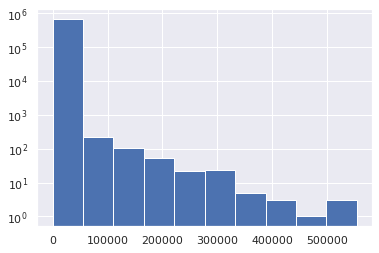

In [42]:
diario_df["comprimento"].hist(log=True)

## Boxsplot

Text(0.5, 1.0, 'Boxplot do comprimento dos segmentos com outliers')

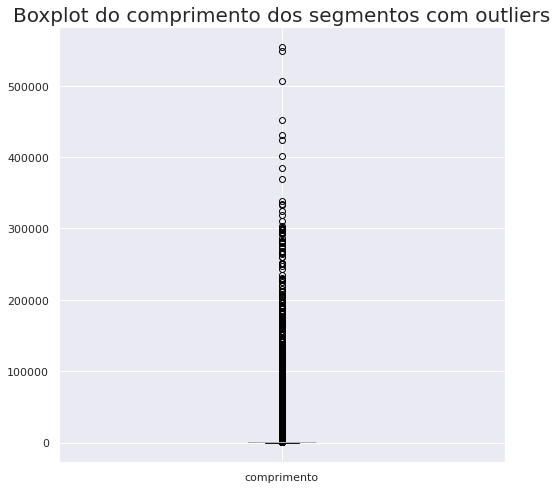

In [43]:
diario_df.boxplot("comprimento", figsize=(8,8))
plt.title("Boxplot do comprimento dos segmentos com outliers", fontsize=20)

Text(0.5, 1.0, 'Boxplot do comprimento dos segmentos sem outliers')

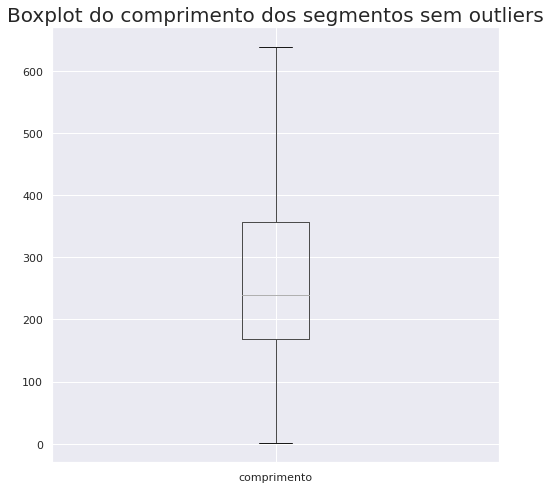

In [45]:
diario_df.boxplot("comprimento", showfliers=False, figsize=(8,8))
plt.title("Boxplot do comprimento dos segmentos sem outliers", fontsize=20)

# Licitações

In [4]:
licitacoes = pd.read_csv("/dados01/workspace/ufmg.m07dcc/M05-dev/indexer/indices/licitacoes/32-licitacoes-das-obras-com_entidades.csv")
licitacoes = licitacoes[['titulo', 'conteudo', 'tipo_documento', 'fonte', 'instancia', "data"]]
licitacoes.columns = ['titulo', 'materia', 'subtitulo', 'publicador', 'origin', "id"]

In [6]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')

sizes = []
for idx, row in tqdm(licitacoes.iterrows(), total = len(licitacoes)):
    sizes.append(len(tokenizer(row["materia"])["input_ids"]))

100%|█████████████████████████████████████████████| 11240/11240 [00:42<00:00, 267.59it/s]


Text(0.5, 1.0, 'Boxplot do comprimento dos segmentos sem outliers')

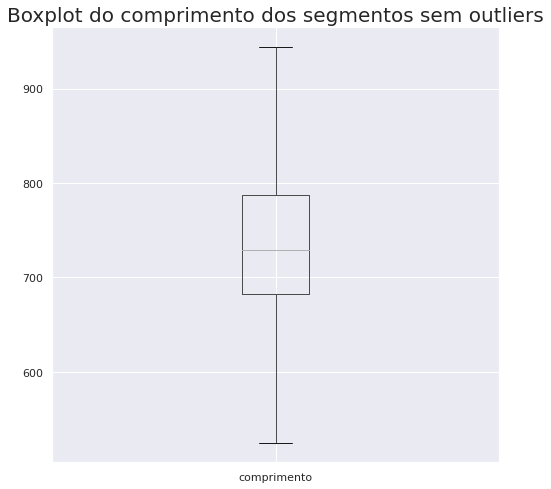

In [7]:
licitacoes["comprimento"] = sizes
licitacoes.boxplot("comprimento", showfliers=False, figsize=(8,8))
plt.title("Boxplot do comprimento dos segmentos sem outliers", fontsize=20)

# Processos

In [10]:
processos = pd.read_csv("/dados01/workspace/ufmg.m07dcc/M05-dev/indexer/indices/processos/27-tribunais-regionais-federais-trf2-com_metadata.csv")
processos = processos[['conteudo', 'fonte', 'numero_processo', 'titulo', 'tipo_documento', 'instancia']]
processos.columns = ['materia', 'ṕublicador', 'id', 'titulo', 'subtitulo', "origin"]
df = processos
df = df[df["materia"].apply(bool)]
df = df[df["materia"].apply(lambda x: type(x) == str)]
df = df[df["materia"].apply(lambda x: len(x) > 20)]

In [11]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')

sizes = []
for idx, row in tqdm(df.iterrows(), total = len(df)):
    sizes.append(len(tokenizer(row["materia"])["input_ids"]))

100%|███████████████████████████████████████████| 164455/164455 [11:14<00:00, 243.66it/s]


Text(0.5, 1.0, 'Boxplot do comprimento dos segmentos sem outliers')

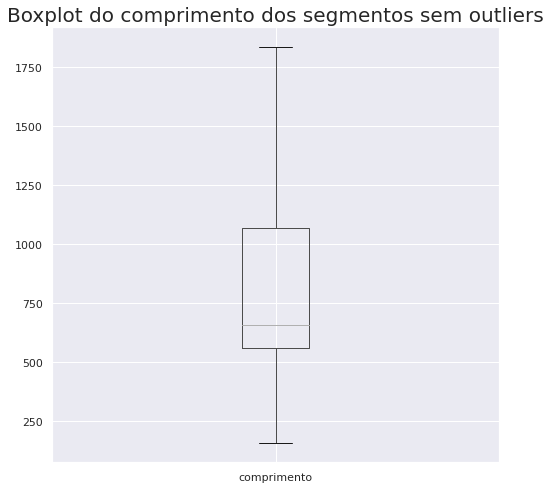

In [12]:
df["comprimento"] = sizes
df.boxplot("comprimento", showfliers=False, figsize=(8,8))
plt.title("Boxplot do comprimento dos segmentos sem outliers", fontsize=20)